In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from __future__ import division
import datetime

In [2]:
!pip install pandas_datareader

In [3]:
from pandas_datareader import data

In [4]:
df = pd.read_csv("/Users/keshavdadhich/Documents/Algorithmic Trading/Bitcoin_Historical_Data.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,13/10/2024,63156.1,63284.6,62054.2,62236.5,62236.5,0
1,12/10/2024,62565.8,63284.6,62680.0,62707.2,62707.2,0
2,11/10/2024,60612.4,63037.9,62486.1,62538.0,62538.0,0
3,10/10/2024,60857.1,60698.5,60080.6,60659.6,60659.6,0
4,09/10/2024,62389.1,60947.5,60370.7,60888.8,60888.8,0


In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

Feature construction

We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

Our dataset is built using raw data comprising of a 5-year price series for four different stocks. The individual stocks and index data consists of Date, Open, High, Low, Close and Volume. Using this data we calculated our indicators based on various technical indicators i.e. Exponential Moving Average, Stochastic Oscillator %K and %D, Relative Strength Index(RSI), Rate Of Change(ROC), Momentum (MOM).

In [6]:
# Initialize the `signals` DataFrame with the `signal` column
df['signal'] = 0.0

# Create short simple moving average over the short window
df['short_mavg'] = df['Close'].rolling(window=30, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
df['long_mavg'] = df['Close'].rolling(window=120, min_periods=1, center=False).mean()

# Create signals
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

In [7]:
#calculation of exponential moving average
def EMA(dataf, n):
    EMA = pd.Series(dataf['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
df['EMA21'] = EMA(df, 21)
df['EMA63'] = EMA(df, 63)
df['EMA252'] = EMA(df, 252)
df.head()

#calculation of rate of change
def ROC(dataf, n):  
    M = dataf.diff(n - 1)  
    N = dataf.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
df['ROC21'] = ROC(df['Close'], 21)
df['ROC63'] = ROC(df['Close'], 63)

#Calculation of price momentum
def MOM(dataf, n):   
    MOM = pd.Series(dataf.diff(n), name='Momentum_' + str(n))   
    return MOM
df['MOM21'] = MOM(df['Close'], 21)
df['MOM63'] = MOM(df['Close'], 63)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period - 1, adjust=False).mean() / d.ewm(com=period - 1, adjust=False).mean()         #rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
 return 100 - 100 / (1 + rs)
df['RSI21'] = RSI(df['Close'], 21)
df['RSI63'] = RSI(df['Close'], 63)
df['RSI252'] = RSI(df['Close'], 252)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(window=n).min()) / (high.rolling(window=n).max() - low.rolling(window=n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(window=n).min()) / (high.rolling(window=n).max() - low.rolling(window=n).min())) * 100
 STOD = STOK.rolling(window=3).mean()
 return STOD
df['%K21'] = STOK(df['Close'], df['Low'], df['High'], 21)
df['%D21'] = STOD(df['Close'], df['Low'], df['High'], 21)
df['%K63'] = STOK(df['Close'], df['Low'], df['High'], 63)
df['%D63'] = STOD(df['Close'], df['Low'], df['High'], 63)
df['%K252'] = STOK(df['Close'], df['Low'], df['High'], 252)
df['%D252'] = STOD(df['Close'], df['Low'], df['High'], 252)

In [8]:
#Calculation of moving average
def MA(dataf, n):
    MA = pd.Series(dataf['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
df['MA21'] = MA(df, 21)
df['MA63'] = MA(df, 63)
df['MA252'] = MA(df, 252)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,signal,short_mavg,long_mavg,...,RSI252,%K21,%D21,%K63,%D63,%K252,%D252,MA21,MA63,MA252
2984,03/11/2015,359.3,416.8,354.6,247.60,247.60,0,0.0,311.625667,375.436833,...,45.038643,-22.355289,-22.918530,-22.355289,-21.926383,-9.263854,-8.697270,282.518095,338.098254,420.849841
2985,02/11/2015,323.0,365.8,319.8,249.50,249.50,0,0.0,308.727000,374.418917,...,45.050752,-21.407186,-21.570193,-21.407186,-21.570193,-8.870968,-8.938517,278.684762,335.164286,418.808214
2986,01/11/2015,311.2,324.3,304.7,246.30,246.30,0,0.0,304.367000,373.337833,...,45.033975,-23.003992,-22.255489,-23.003992,-22.255489,-9.532672,-9.222498,275.413333,332.169048,416.766984
2987,31/10/2015,327.1,333.3,304.6,245.39,245.39,0,0.0,300.238667,372.248750,...,45.029187,-23.458084,-22.623087,-23.458084,-22.623087,-9.720844,-9.374828,271.367143,328.842063,414.742857
2988,30/10/2015,313.6,334.9,310.8,243.95,243.95,0,0.0,295.470333,371.067750,...,45.021583,-24.176647,-23.546241,-24.176647,-23.546241,-10.018610,-9.757375,267.989048,326.077143,412.678294


In [9]:
#Dealing with rows that contain NAN

df.isnull().sum()
datasub=df.dropna()
datasub.isnull().sum()
datasub.head()

,Date,Open,High,Low,Close,Adj Close,Volume,signal,short_mavg,long_mavg,...,RSI252,%K21,%D21,%K63,%D63,%K252,%D252,MA21,MA63,MA252
253,06/07/2023,30499.9,30161.0,29757.4,30114.0,30114.0,0,0.0,29837.330000,55331.602500,...,44.965330,41.483549,46.271473,2.878463,3.152474,2.878463,3.152474,30086.219048,46289.671429,58905.639683
254,05/07/2023,30834.0,30559.0,30353.6,30502.8,30502.8,0,0.0,29884.573333,55020.820833,...,45.032855,56.767169,48.766330,3.753138,3.295254,3.753138,3.295254,30136.980952,45698.595238,58778.515873
255,04/07/2023,31262.2,30861.7,30756.3,30849.8,30849.8,0,0.0,29941.493333,54713.606667,...,45.093220,70.407642,56.219453,4.533777,3.721793,4.533777,3.721793,30213.138095,45114.476190,58660.223016
256,03/07/2023,30756.8,31326.5,31101.8,31241.8,31241.8,0,0.0,30011.046667,54402.192500,...,45.161525,81.251299,69.475370,5.415651,4.567522,5.415651,4.567522,30314.333333,44567.933333,58542.576190
257,02/07/2023,30544.1,30790.4,30594.4,30779.8,30779.8,0,0.0,30047.983333,54090.820833,...,45.095145,55.926938,69.195293,4.376299,4.775242,4.376299,4.775242,30365.800000,44006.733333,58417.220238


In [10]:
#excluding columns that are not needed for our prediction.

datasubs=datasub.drop(['Close','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)
datasubs.head()

,Date,Adj Close,signal,EMA21,EMA63,EMA252,ROC21,ROC63,MOM21,MOM63,...,RSI252,%K21,%D21,%K63,%D63,%K252,%D252,MA21,MA63,MA252
253,06/07/2023,30114.0,0.0,31372.623164,41741.256430,54861.985206,2.300522,-55.545124,898.8,-39295.1,...,44.965330,41.483549,46.271473,2.878463,3.152474,2.878463,3.152474,30086.219048,46289.671429,58905.639683
254,05/07/2023,30502.8,0.0,31293.548331,41389.947594,54640.100485,4.281294,-54.910398,1066.0,-37237.8,...,45.032855,56.767169,48.766330,3.753138,3.295254,3.753138,3.295254,30136.980952,45698.595238,58778.515873
255,04/07/2023,30849.8,0.0,31253.207574,41060.470702,54423.658201,5.952254,-53.025855,1599.3,-36799.5,...,45.093220,70.407642,56.219453,4.533777,3.721793,4.533777,3.721793,30213.138095,45114.476190,58660.223016
256,03/07/2023,31241.8,0.0,31252.170522,40753.549454,54213.002744,5.194788,-52.760851,2125.1,-34432.2,...,45.161525,81.251299,69.475370,5.415651,4.567522,5.415651,4.567522,30314.333333,44567.933333,58542.576190
257,02/07/2023,30779.8,0.0,31209.227747,40441.783396,54000.314683,3.100056,-55.921116,1080.8,-35355.6,...,45.095145,55.926938,69.195293,4.376299,4.775242,4.376299,4.775242,30365.800000,44006.733333,58417.220238


Understanding the dataset using numbers and visuals

The most significant pre-requisite for predictive modeling is to have a good understanding of the dataset. The understanding helps in: Data transforms Choosing the right machine learning algorithms Explains the results obtained from the model Improves its accuracy We would like to see if we have a balanced data or not. And also visualize the correlation between the various features

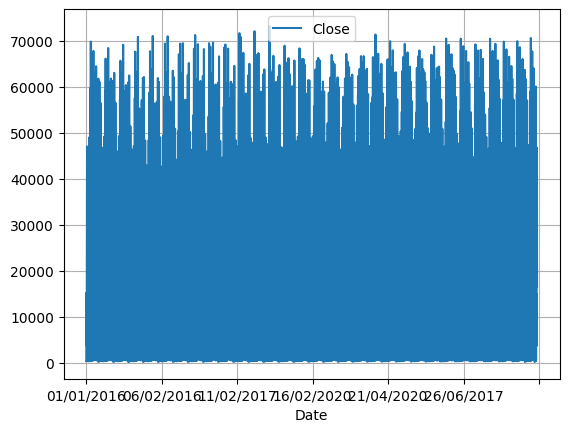

upward  39.21783625730994% out of 2736 total datasize


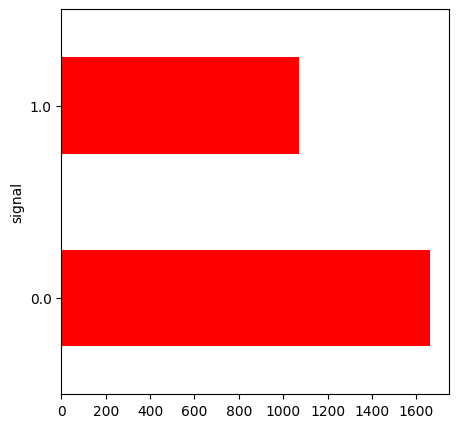

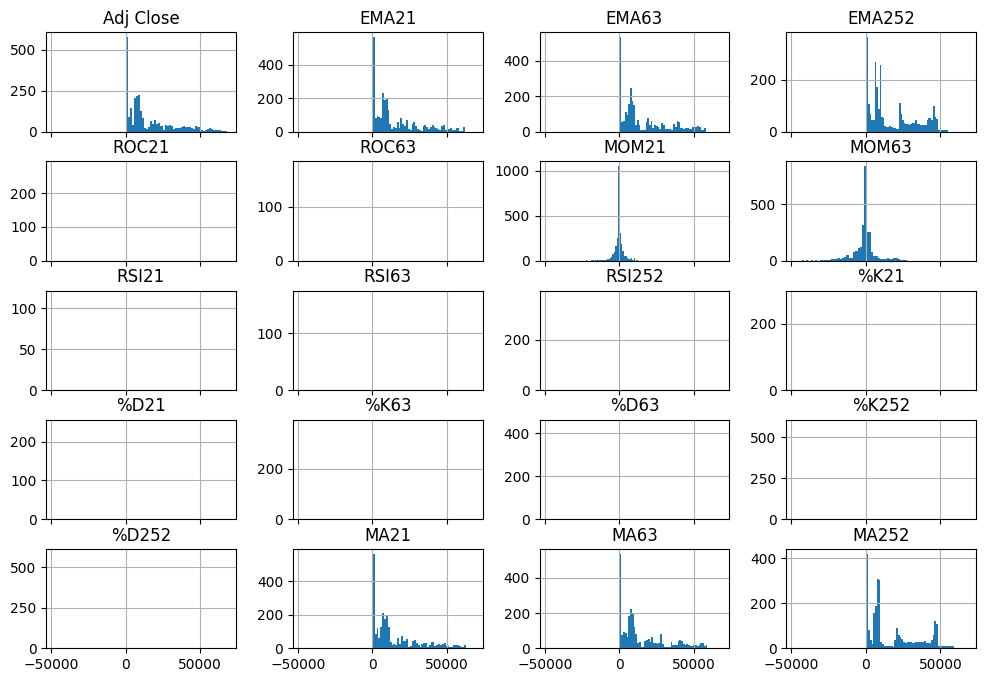

In [12]:
## Use pivot_table with specified parameters
daily_close_px = df.pivot_table(index='Date', values='Close')

# Plot the data
daily_close_px.plot(grid=True)
plt.show()

fig = plt.figure()
fig.set_size_inches(5,5)
data_s = datasubs.groupby(['signal']).size()
names=['EMA21','EMA63','EMA252','ROC21','ROC63','MOM21','MOM63','RSI21','RSI63','RSI252','K21','D21','%K63','%D63','%K252','%D252','MA21','MA63','MA252']

print("upward  {}% out of {} total datasize".format(100* data_s[1]/(data_s[1]+data_s[0]), data_s[1]+data_s[0]))
plot = data_s.plot(kind='barh', color='red')
X=datasubs.drop(['signal'], axis=1)
y=datasubs['signal']

# Plot the distributions of each input variable 
X.hist(bins=50, sharex=True, figsize=(12,8))
plt.show()




In [16]:
X['data'] = X['data'].astype('int64')  # Convert datetime to UNIX timestamp


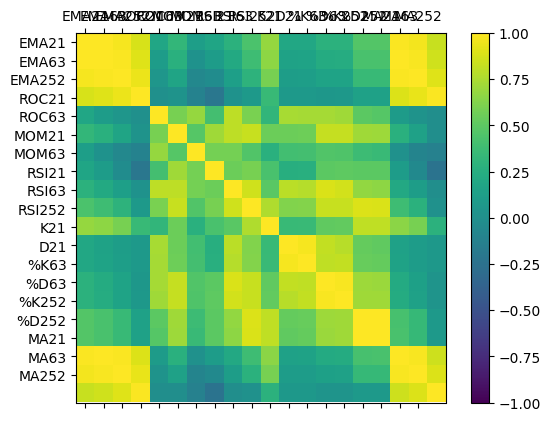

In [17]:
X = X.select_dtypes(include=[np.number])
correlations = X.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,19,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

Feature Selection

Feature selection is the process of selecting a subset of features that are most relevant for model construction which aid in creating an accurate predictive model. There are a wide range of feature selection algorithms, and these mainly fall in one of the three categories:

Filter method– selects features by assigning a score to them using some statistical measure. Wrapper method– evaluates different subset of features, and determines the best subset. Embedded method – This method figures out which of the features give the best accuracy while the model is being trained.

In our model, we will use filter method utilising the random.forest.importance function. The random.forest.importance function rates the importance of each feature in the classification of the outcome, i.e. class variable. The function returns a data frame containing the name of each attribute and the importance value based on the mean decrease in accuracy.

In [18]:
forest = RandomForestClassifier(n_estimators=500,random_state=1,n_jobs=-1)
forest.fit(X, y)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=1)

           Importance
Adj Close    1.552495
%D21         1.838379
%K21         1.865865
MA63         2.070154
EMA63        2.107402
EMA21        2.166878
MOM21        2.186901
RSI21        2.243190
EMA252       2.400690
MA252        2.444891
MA21         2.655519
ROC21        2.889392
%K63         3.587808
RSI252       3.917862
%D63         4.541591
MOM63        9.018550
ROC63       10.474517
RSI63       11.138683
%K252       13.478641
%D252       17.420590


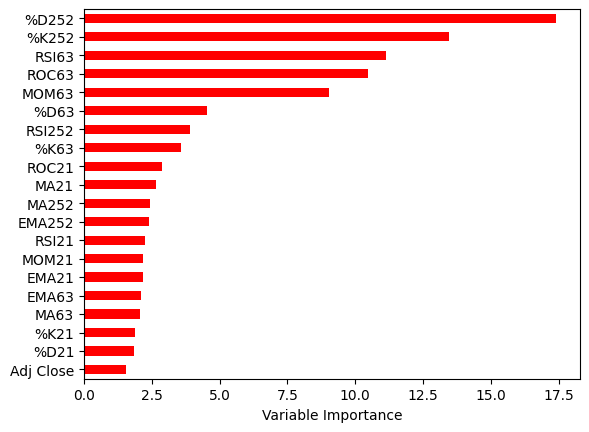

In [19]:
Importance = pd.DataFrame({'Importance':forest.feature_importances_*100}, index=X.columns)
print(Importance.sort_values('Importance', axis=0, ascending=True))
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm,neighbors
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

Splitting

After creating models for unseen data, we will check their accuracy thanks to statistical methods. We evaluate the accuracy of the best model on actual unseen data to have the estimation more concrete. Meaning that we will use the algorithm on the training set and use the model on the test set afterwards for validation. We split the dataset into 80% training set and 20% test set.

In [32]:
# Split the dataset
X_1 = datasub.drop(['signal'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_1, y, test_size=0.3, random_state=1)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# Drop specific columns
X_train_1 = X_train.drop(['Close', 'High', 'Low', 'Open', 'Volume', 'short_mavg', 'long_mavg'], axis=1)
X_test_1 = X_test.drop(['Close', 'High', 'Low', 'Open', 'Volume', 'short_mavg', 'long_mavg'], axis=1)

# Handle non-numeric columns
X_train_1 = X_train_1.select_dtypes(include=[np.number])  # Select numeric columns
X_test_1 = X_test_1.select_dtypes(include=[np.number])   # Select numeric columns

# Scale the data
rs = RobustScaler()
rs.fit(X_train_1)
X_train_std = rs.transform(X_train_1)
X_test_std = rs.transform(X_test_1)


(1915, 28) (1915,)
(821, 28) (821,)


Modelling

In order to know which algorithm technic is the best for our strategy, we evaluate 5 non linear different methods:

K-Nearest Neighbors (KNN)
Classification and Regression Trees (CART)
Support Vector Machines (SVM)
Random Forest (RF)
Gaussian Naïve Bayes (NB)
To ensure the comparatibility of the results (use the same data splits), the random number (seed = 1) is reset before each run.

In [33]:
# Spot Check Algorithms
data_Selected = []
data_Selected.append(('KNN', KNeighborsClassifier()))
data_Selected.append(('CART', DecisionTreeClassifier()))
data_Selected.append(('SVM', SVC()))
data_Selected.append(('RF', RandomForestClassifier()))
data_Selected.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
score=['f1','accuracy','precison','recall']
for name, model in data_Selected:
    kfold = model_selection.KFold(n_splits=10, random_state=1, shuffle=True)
    cv_results =cross_val_score(model, X_train_std, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    output = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(output)

KNN: 0.961889 (0.023370)
CART: 0.954039 (0.014565)
SVM: 0.946226 (0.014752)
RF: 0.980157 (0.010126)
NB: 0.845397 (0.021289)


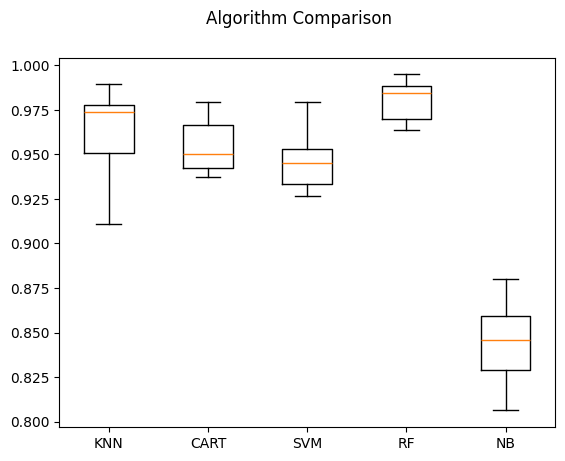

In [34]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [35]:
rf = RandomForestClassifier(n_estimators=500, min_samples_split=5,min_samples_leaf =2,max_features = 10,n_jobs=4,criterion='gini')
predy=rf.fit(X_train_std, Y_train)

In [36]:
predr= rf.predict(X_test_std)


In [37]:
print(accuracy_score(Y_test, predr))
print(confusion_matrix(Y_test, predr))
print(classification_report(Y_test, predr))

0.9805115712545676
[[481  14]
 [  2 324]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       495
         1.0       0.96      0.99      0.98       326

    accuracy                           0.98       821
   macro avg       0.98      0.98      0.98       821
weighted avg       0.98      0.98      0.98       821



In [38]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix,f1_score

def pltcm(ax, y_test, y_pred, classes, title, th=0.7, cmap=plt.cm.Reds):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_test, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tickmarks = np.arange(len(classes))
    ax.set_xticks(tickmarks)
    ax.set_yticks(tickmarks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="green" if cm[i, j] > thresh else "yellow")
    ax.set_ylabel('Actual')
    ax.set_xlabel('Prediction')

def pltauc(ax, y_train, y_pred, y_test, y_tpred, th=0.7):

    y_predl = (y_pred>th).astype(int)
    y_tpredl  = (y_tpred>th).astype(int)

    fpr_tr, tpr_tr, _ = roc_curve(y_train,y_pred)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
    acc_tr = accuracy_score(y_train, y_predl)

    fpr_ts, tpr_ts, _ = roc_curve(y_test,y_tpred)
    roc_auc_ts = auc(fpr_ts, tpr_ts)
    acc_ts = accuracy_score(y_test, y_tpredl)

    ax.plot(fpr_tr, tpr_tr)
    ax.plot(fpr_ts, tpr_ts)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_tr, roc_auc_tr)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_ts, roc_auc_ts)
    ax.legend([train_text, test_text])

def result(es,threshold,X_train,X_test,y_train,y_test):
    y_pred = es.predict(X_train)
    y_tpred = es.predict(X_test)

    fig,ax = plt.subplots(1,3)
    fig.set_size_inches(15,5)
    pltcm(ax[0],  y_train, y_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
    pltcm(ax[1],  y_test, y_tpred,   [0,1], 'Confusion matrix (TEST)', threshold)
    pltauc(ax[2], y_train, y_pred, y_test, y_tpred, threshold)
    plt.tight_layout()
    plt.show()
    
def btf1(es,X_test,y_test):
    thresholds = np.linspace(0.3,0.6,100)
    y_tpred = es.predict(X_test)
    score_set = []
    index_threshold = 0
    sum_score = 0
    for threshold in thresholds:
        y_tpred1  = (y_tpred > threshold).astype(int)
        score = f1_score(y_test, y_tpred1)
        score_set.append(score)
    for i in range(95):
        temp = sum(score_set[i:i+5])
        if temp > sum_score:
            sum_score = temp
            index_threshold = i+2 # the average threshold
    return thresholds[index_threshold],sum_score/5

def testf1(es,bestthreshold,X_test,y_test):
    y_tpred = es.predict(X_test)
    y_tpred1  = (y_tpred > bestthreshold).astype(int)
    score = f1_score(y_test, y_tpred1)
    return score

test f1: 0.9759036144578314 train f1: 0.9986595174262736


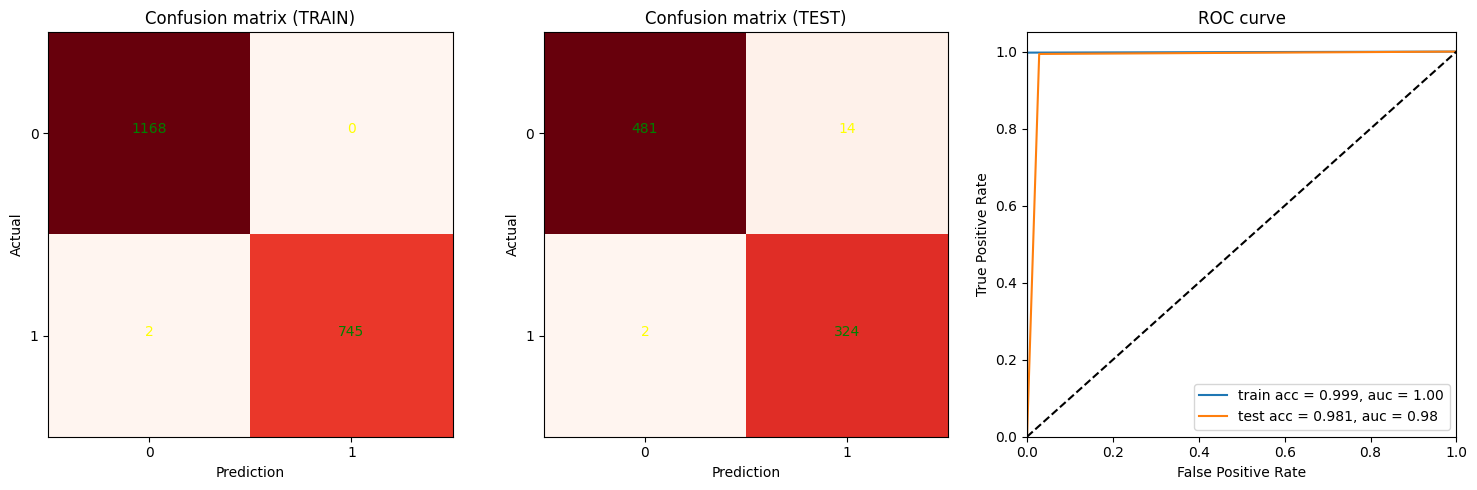

In [39]:
bestthreshold,bestf1 = btf1(rf,X_train_std, Y_train)
testf1 = testf1(rf,bestthreshold,X_test_std,Y_test)
print('test f1:',testf1,'train f1:',bestf1)
result(rf,bestthreshold,X_train_std,X_test_std, Y_train,Y_test)

,signal_pred,signal_actual,Market Returns,Actual Returns,Strategy Returns
1149,0.0,0.0,NaN,NaN,NaN
1280,0.0,0.0,-0.714083,-0.00000,-0.00000
811,1.0,1.0,3.930033,0.00000,0.00000
2960,0.0,0.0,-0.992130,-0.99213,-0.99213
681,1.0,1.0,98.286082,0.00000,0.00000


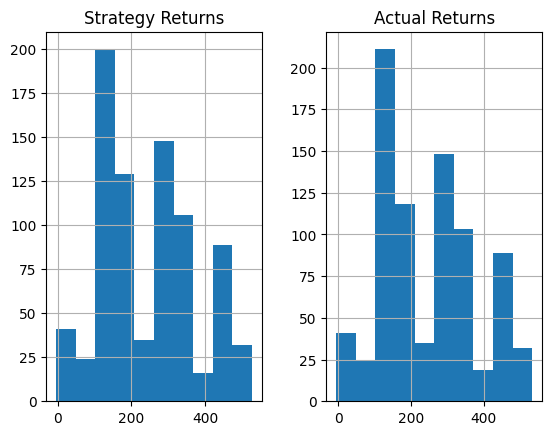

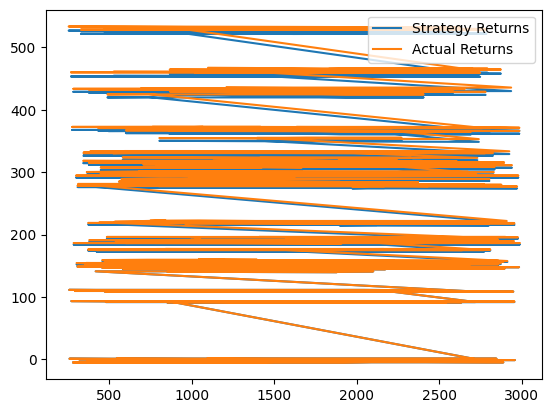

In [41]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_test.index)
backtestdata['signal_pred'] = predr
backtestdata['signal_actual'] = Y_test
backtestdata['Market Returns'] = X_test['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()
backtestdata.head()
